# Preparations

In [1]:
import Pkg
Pkg.DEFAULT_IO[] = stdout;

#### Fetch Required Packages

In [2]:
using BifurcationKit
using Revise
using ForwardDiff
using Parameters
using Setfield
using Plots
using LinearAlgebra
using DifferentialEquations

┌ Info: Precompiling BifurcationKit [0f109fa4-8a5d-4b75-95aa-f515264e7665]
└ @ Base loading.jl:1423
┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1423
┌ Info: Precompiling DifferentialEquations [0c46a032-eb83-5123-abaf-570d42b7fbaa]
└ @ Base loading.jl:1423


#### Other

In [3]:
gr(); 
default(framestyle=:box,grid=false,fmt=:png,guidefontsize=14);

In [4]:
const BK = BifurcationKit
norminf(x) = norm(x, Inf);

# Make Figures

In [5]:
function fold_bif_func!(dz, z, p, t)     ### New 
	dz[1] = z[1]^2-p[1]
	dz
end
fold_bif_func(z, p) = fold_bif_func!(similar(z), z, p, 0)
F = (z, p) -> fold_bif_func!(similar(z), z, p, 0)  ### Changed Function name (also later) ###
J = (z,p) -> ForwardDiff.jacobian(x -> fold_bif_func(x,p), z)
jet = BK.getJet(F, J);

# parameter values
par_tm = [10.0]     ### New parameter values ###

# initial condition
z0 = [sqrt(2)];     ### New initial condition ###

# continuation options
opts_br = ContinuationPar(pMin = -2.0, pMax = 10.0,
	# parameters to have a smooth result
	ds = -0.04, dsmax = 0.05,  maxSteps=1000000,
	# this is to detect bifurcation points precisely with bisection
	detectBifurcation = 3,
	# Optional: bisection options for locating bifurcations
	nInversion = 8, maxBisectionSteps = 25, nev = 3)

# continuation of equilibria
br_fold, = continuation(F,J, z0, par_tm, (@lens _[1]), opts_br;
	recordFromSolution = (x, p) -> x[1],
	tangentAlgo = BorderedPred(),
	plot = false, normC = norminf);

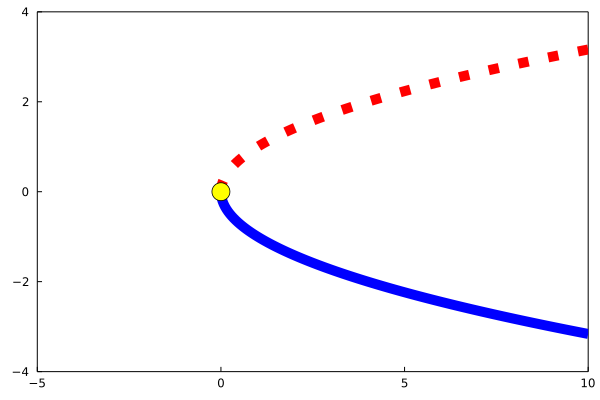

In [6]:
lw = 10; la = 1.0;

idx = findfirst(map(e -> maximum(real.(e)) < 0.0 ,getfield.(br_fold.eig,:eigenvals)))
plot(getfield.(br_fold.branch,:param)[1:idx],getfield.(br_fold.branch,:x)[1:idx],color=:red,linestyle=:dot,lw=lw,la=la,xguide="",label="")
plot!(getfield.(br_fold.branch,:param)[idx:end],getfield.(br_fold.branch,:x)[idx:end],xlimit=(-5.0,10.0),ylimit=(-4.0,4.0),color=:blue,lw=lw,la=la,xguide="",label="")
fold_plot = scatter!((0.0,0.0),markersize=10,label="",color=:yellow)

In [7]:
function brus!(dz, z, p, t)     ### New function ###
	A, B = p
	X, Y = z
	dz[1] = (A + Y*X^2 - B*X-X)
	dz[2] = (B*X - Y*X^2)
	dz
end
brus(z, p) = brus!(similar(z), z, p, 0)
F = (z, p) -> brus!(similar(z), z, p, 0)  ### Changed Function name (also later) ###
J = (z,p) -> ForwardDiff.jacobian(x -> brus(x,p), z)
jet = BK.getJet(F, J)

# parameter values
par_tm = [1.0,1.0]     ### New parameter values ###

# initial condition
z0 = [1.0, 1.0];     ### New initial condition ###

# continuation options
opts_br = ContinuationPar(pMin = 1.0, pMax = 4.0,
	# parameters to have a smooth result
	ds = 0.04, dsmax = 0.05,
	# this is to detect bifurcation points precisely with bisection
	detectBifurcation = 3,
	# Optional: bisection options for locating bifurcations
	nInversion = 8, maxBisectionSteps = 25, nev = 3)

# continuation of equilibria
br_supH, = continuation(F,J, z0, par_tm, (@lens _[2]), opts_br;
	recordFromSolution = (x, p) -> x[1],
	tangentAlgo = BorderedPred(),
	plot = false, normC = norminf)

# newton parameters
optn_po = NewtonPar(verbose = false, tol = 1e-8,  maxIter = 10);

# continuation parameters
opts_po_cont = ContinuationPar(dsmax = 0.1, ds= -0.0001, dsmin = 1e-4, pMax = 4., pMin=1.0,     ### Changed pMin and pMax ###
	maxSteps = 110, newtonOptions = (@set optn_po.tol = 1e-7),
	nev = 3, precisionStability = 1e-8, detectBifurcation = 3, plotEveryStep = 10, saveSolEveryStep=1)

# arguments for periodic orbits
args_po = (	recordFromSolution = (x, p) -> (xtt = BK.getPeriodicOrbit(p.prob, x, p.p);
		return (max = maximum(xtt.u[1,:]),
				min = minimum(xtt.u[1,:]),
				period = x[end])),
	plotSolution = (x, p; k...) -> begin
		xtt = BK.getPeriodicOrbit(p.prob, x, p.p)
		plot!(xtt.t, xtt.u[1,:]; label = "X", k...)
		plot!(xtt.t, xtt.u[2,:]; label = "Y", k...)  ### Removed one variable from plot ###
		plot!(br_supH,subplot=1, putbifptlegend = false)
		end,
	normC = norminf)

Mt = 200 # number of time sections
	br_supH_potrap, utrap = continuation(jet...,
	# we want to branch form the 4th bif. point
	br_supH, 1, opts_po_cont,                 ### Now uses 1st bp ###
	# we want to use the Trapeze method to locate PO
	PeriodicOrbitTrapProblem(M = Mt);
	# this jacobian is specific to ODEs
	# it is computed using AD and
	# updated inplace
	linearPO = :Dense, δp = 0.005,
	# regular continuation options
	verbosity = 0,	plot = false,
	args_po...);

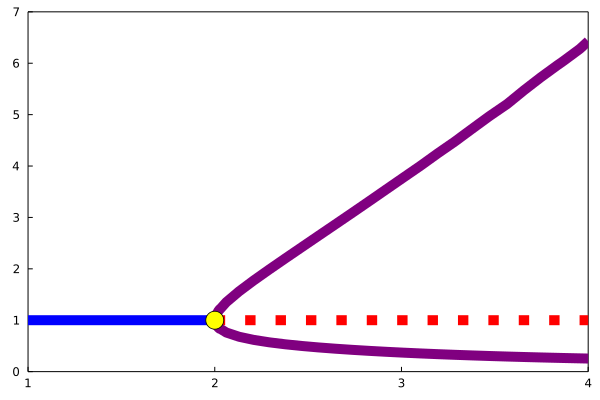

In [8]:
lw = 10; la = 1.0;

idx = findfirst(map(e -> maximum(real.(e)) > 0.0 ,getfield.(br_supH.eig,:eigenvals)))
plot(getfield.(br_supH.branch,:param)[1:idx],getfield.(br_supH.branch,:x)[1:idx],xlimit=(1.0,4.0),ylimit=(0.0,7.0),color=:blue,lw=lw,la=la,xguide="",label="")
plot!(getfield.(br_supH.branch,:param)[idx:end],getfield.(br_supH.branch,:x)[idx:end],xlimit=(1.0,4.0),ylimit=(0.0,7.0),color=:red,linestyle=:dot,lw=lw,la=la,xguide="",label="")
plot!(getfield.(br_supH_potrap.γ.branch,:param),getfield.(br_supH_potrap.γ.branch,:max),xlimit=(1.0,4.0),ylimit=(0.0,7.0),color=:purple,lw=lw,la=la,xguide="",label="")
plot!(getfield.(br_supH_potrap.γ.branch,:param),getfield.(br_supH_potrap.γ.branch,:min),xlimit=(1.0,4.0),ylimit=(0.0,7.0),color=:purple,lw=lw,la=la,xguide="",label="")
supcricitcal_hopf_plot = scatter!((2.0,1.0),markersize=10,label="",color=:yellow)

In [9]:
function brus!(dz, z, p, t)     ### New function ###
	A, B = p
	X, Y = z
	dz[1] = -(A + Y*X^2 - B*X-X)
	dz[2] = -(B*X - Y*X^2)
	dz
end
brus(z, p) = brus!(similar(z), z, p, 0)
F = (z, p) -> brus!(similar(z), z, p, 0)  ### Changed Function name (also later) ###
J = (z,p) -> ForwardDiff.jacobian(x -> brus(x,p), z)
jet = BK.getJet(F, J)

# parameter values
par_tm = [1.0,1.0]     ### New parameter values ###

# initial condition
z0 = [1.0, 1.0];     ### New initial condition ###

# continuation options
opts_br = ContinuationPar(pMin = 1.0, pMax = 4.0,
	# parameters to have a smooth result
	ds = 0.04, dsmax = 0.05,
	# this is to detect bifurcation points precisely with bisection
	detectBifurcation = 3,
	# Optional: bisection options for locating bifurcations
	nInversion = 8, maxBisectionSteps = 25, nev = 3)

# continuation of equilibria
br_subH, = continuation(F,J, z0, par_tm, (@lens _[2]), opts_br;
	recordFromSolution = (x, p) -> x[1],
	tangentAlgo = BorderedPred(),
	plot = false, normC = norminf)

# newton parameters
optn_po = NewtonPar(verbose = false, tol = 1e-8,  maxIter = 10);

# continuation parameters
opts_po_cont = ContinuationPar(dsmax = 0.1, ds= -0.0001, dsmin = 1e-4, pMax = 4., pMin=1.0,     ### Changed pMin and pMax ###
	maxSteps = 110, newtonOptions = (@set optn_po.tol = 1e-7),
	nev = 3, precisionStability = 1e-8, detectBifurcation = 3, plotEveryStep = 10, saveSolEveryStep=1)

# arguments for periodic orbits
args_po = (	recordFromSolution = (x, p) -> (xtt = BK.getPeriodicOrbit(p.prob, x, p.p);
		return (max = maximum(xtt.u[1,:]),
				min = minimum(xtt.u[1,:]),
				period = x[end])),
	plotSolution = (x, p; k...) -> begin
		xtt = BK.getPeriodicOrbit(p.prob, x, p.p)
		plot!(xtt.t, xtt.u[1,:]; label = "X", k...)
		plot!(xtt.t, xtt.u[2,:]; label = "Y", k...)  ### Removed one variable from plot ###
		plot!(br_supH,subplot=1, putbifptlegend = false)
		end,
	normC = norminf)

Mt = 200 # number of time sections
	br_subH_potrap, utrap = continuation(jet...,
	# we want to branch form the 4th bif. point
	br_subH, 1, opts_po_cont,                 ### Now uses 1st bp ###
	# we want to use the Trapeze method to locate PO
	PeriodicOrbitTrapProblem(M = Mt);
	# this jacobian is specific to ODEs
	# it is computed using AD and
	# updated inplace
	linearPO = :Dense, δp = 0.005,
	# regular continuation options
	verbosity = 0,	plot = false,
	args_po...);

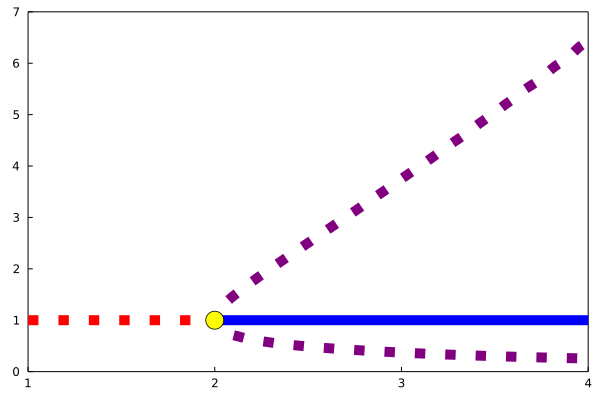

In [10]:
lw = 10; la = 1.0;

idx = findfirst(map(e -> maximum(real.(e)) < 0.0 ,getfield.(br_subH.eig,:eigenvals)))
plot(getfield.(br_subH.branch,:param)[1:idx],getfield.(br_subH.branch,:x)[1:idx],xlimit=(1.0,4.0),ylimit=(0.0,7.0),color=:red,linestyle=:dot,lw=lw,la=la,xguide="",label="")
plot!(getfield.(br_subH.branch,:param)[idx:end],getfield.(br_subH.branch,:x)[idx:end],xlimit=(1.0,4.0),ylimit=(0.0,7.0),color=:blue,lw=lw,la=la,xguide="",label="")
plot!(getfield.(br_subH_potrap.γ.branch,:param),getfield.(br_subH_potrap.γ.branch,:max),xlimit=(1.0,4.0),ylimit=(0.0,7.0),color=:purple,linestyle=:dot,lw=lw,la=la,xguide="",label="")
plot!(getfield.(br_subH_potrap.γ.branch,:param),getfield.(br_subH_potrap.γ.branch,:min),xlimit=(1.0,4.0),ylimit=(0.0,7.0),color=:purple,linestyle=:dot,lw=lw,la=la,xguide="",label="")
subcricitcal_hopf_plot = scatter!((2.0,1.0),markersize=10,label="",color=:yellow)

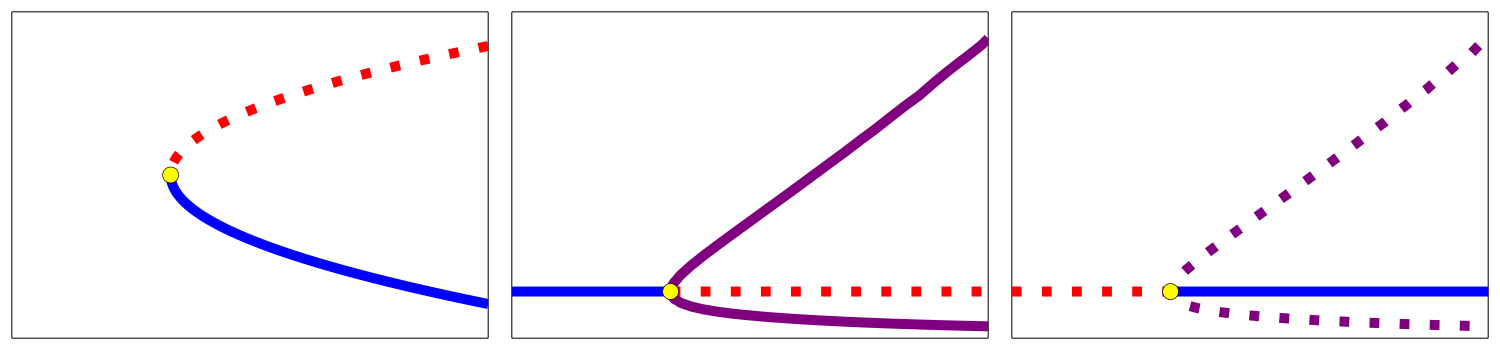

In [11]:
bifurcation_points_plot = plot(fold_plot,supcricitcal_hopf_plot,subcricitcal_hopf_plot,layout=(1,3),size=(1500,350),xticks=[],yticks=[])

In [12]:
savefig(bifurcation_points_plot,"../Figures/Bifurcation_Points/bifurcation_points_base.svg")